# EDA

In [18]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from hyperopt import hp, tpe, Trials, fmin

In [19]:
# dirs
input_dir = '../input/'
working_dir = '../working/'
output_dir = '../output/'

In [20]:
# read data
train = pd.read_pickle(os.path.join(input_dir, 'train.pkl'))
test = pd.read_pickle(os.path.join(input_dir, 'test.pkl'))
sample_submission = pd.read_csv(os.path.join(input_dir, 'sample_submission.csv'), dtype={'fullVisitorId': 'str'})

In [21]:
# divide train into development and validation
dev = train[train['date']<=datetime.datetime(2017,5,31)]
val = train[train['date']>datetime.datetime(2017,5,31)]

TODO: 
1. dateをLGBに入れると型の問題でエラーが出る

In [22]:
# shape data set for modelling
drop_X_cols = ['fullVisitorId', 'date', 'sessionId', 'visitId', 'visitStartTime', 'gclId', 'source']
def divide_y_X(df, drop_X_cols=drop_X_cols):
    y = df['transactionRevenue'].fillna(0)
    X = df.drop(['transactionRevenue']+drop_X_cols, axis=1)
    return y, X

dev_y, dev_X = divide_y_X(dev)
val_y, val_X = divide_y_X(val)

test_X = test.drop(drop_X_cols, axis=1)

TODO: hyperopt使いたい

In [23]:
lgb_params = {
        "objective" : "regression",
        "metric" : "rmse", 
#         "num_leaves" : 30,
#         "min_child_samples" : 100,
#         "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
#         "bagging_seed" : 2018,
        "verbosity" : -1
    }

In [24]:
hyperopt_parameters = {
    'num_leaves': hp.uniform('num_leaves', 10, 1000),
    'min_child_samples': hp.uniform('min_child_samples', 50, 500),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.5),
#     'objective': hp.choice('objective', ['regression'])
}

In [30]:
def objective(args):
    args['num_leaves'] = int(args['num_leaves'])
    args['min_child_samples'] = int(args['min_child_samples'])
    #     args['metric'] = 'rmse'
    # モデルのインスタンス化
    model = lgb.LGBMRegressor(**args, random_state=0)
    # trainデータを使ってモデルの学習
    model.fit(dev_X, np.log1p(dev_y), early_stopping_rounds=1000, eval_set=[(val_X, val_y)])
    # validationデータを使用して、ラベルの予測
    # 予測ラベルと正解ラベルを使用してRMSEを計算
    pred_val = np.expm1(model.predict(val_X)) #, num_iteration=model.best_iteration
    sbm_pred_val = format_as_submission(pred_val, val)
    sbm_val_y = format_as_submission(val_y, val)
    rmse = np.sqrt(mean_squared_error(sbm_val_y, sbm_pred_val))
    
    return rmse

In [31]:
# iterationする回数
max_evals = 10
# 試行の過程を記録するインスタンス
trials = Trials()

best = fmin(
    # 最小化する値を定義した関数
    objective,
    # 探索するパラメータのdictもしくはlist
    hyperopt_parameters,
    # どのロジックを利用するか、基本的にはtpe.suggestでok
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    # 試行の過程を出力
    verbose=-1
)

[1]	valid_0's l2: 2.51413e+15
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l2: 2.51413e+15
[3]	valid_0's l2: 2.51413e+15
[4]	valid_0's l2: 2.51413e+15
[5]	valid_0's l2: 2.51413e+15
[6]	valid_0's l2: 2.51413e+15
[7]	valid_0's l2: 2.51413e+15
[8]	valid_0's l2: 2.51413e+15
[9]	valid_0's l2: 2.51413e+15
[10]	valid_0's l2: 2.51413e+15
[11]	valid_0's l2: 2.51413e+15
[12]	valid_0's l2: 2.51413e+15
[13]	valid_0's l2: 2.51413e+15
[14]	valid_0's l2: 2.51413e+15
[15]	valid_0's l2: 2.51413e+15
[16]	valid_0's l2: 2.51413e+15
[17]	valid_0's l2: 2.51413e+15
[18]	valid_0's l2: 2.51413e+15
[19]	valid_0's l2: 2.51413e+15
[20]	valid_0's l2: 2.51413e+15
[21]	valid_0's l2: 2.51413e+15
[22]	valid_0's l2: 2.51413e+15
[23]	valid_0's l2: 2.51413e+15
[24]	valid_0's l2: 2.51413e+15
[25]	valid_0's l2: 2.51413e+15
[26]	valid_0's l2: 2.51413e+15
[27]	valid_0's l2: 2.51413e+15
[28]	valid_0's l2: 2.51413e+15
[29]	valid_0's l2: 2.51413e+15
[30]	valid_0's l2: 2.51413e+15
[31]	valid_0's 

KeyboardInterrupt: 

In [26]:
# learning
lgb_params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
#         "bagging_seed" : 2018,
        "verbosity" : -1
    }

dev_lgb = lgb.Dataset(dev_X, label=np.log1p(dev_y))
val_lgb = lgb.Dataset(val_X, label=np.log1p(val_y))

model = lgb.train(lgb_params, train_set=dev_lgb, num_boost_round=1000, valid_sets=[val_lgb], early_stopping_rounds=100, verbose_eval=100)

# prediction
pred_val = np.expm1(model.predict(val_X, num_iteration=model.best_iteration))
pred_test = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))

C:\Users\hiroshi_kuriyama\AppData\Local\conda\conda\envs\kaggle_gstore_revenue\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.7247
[200]	valid_0's rmse: 1.72352
[300]	valid_0's rmse: 1.72574
Early stopping, best iteration is:
[215]	valid_0's rmse: 1.72271


In [27]:
# formatting pred np.array into Dataframe and grouping by 'fullVisitorId'
def format_as_submission(y=pred_val, ori_data=val):
    
    # negative can not be in log
    y[y<0] = 0
    
    # to Dataframe
    y_df = pd.DataFrame(
        {
            'fullVisitorId': ori_data['fullVisitorId'],
            'PredictedLogRevenue': y
        }
    )
    
    # grouping
    submission = y_df.groupby('fullVisitorId')['PredictedLogRevenue'].sum()
    submission = submission.to_frame()
    submission['PredictedLogRevenue'] = np.log1p(submission['PredictedLogRevenue'])
    return submission

In [28]:
sbm_pred_val = format_as_submission(pred_val, val)
sbm_val_y = format_as_submission(val_y, val)
sbm_pred_test = format_as_submission(pred_test, test)

In [29]:
# evaluation
rmse = np.sqrt(mean_squared_error(sbm_val_y, sbm_pred_val))
print("RMSE: \n", rmse)

RMSE: 
 1.7634621155708619


In [10]:
# save submission file
sbm_pred_test.to_csv(os.path.join(output_dir, 'submission_20181010.csv'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000232025D0358>]],
      dtype=object)

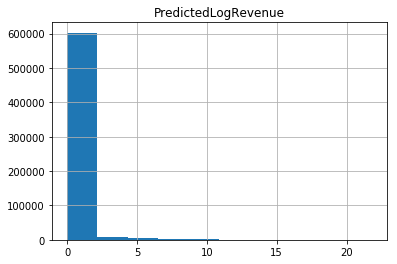

In [11]:
sbm_pred_test.hist()

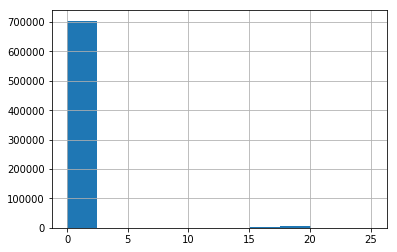

In [12]:
np.log(train.groupby('fullVisitorId')['transactionRevenue'].sum()+1).hist()

In [13]:
# trainとtestで重複していない値の数
col_diff_dict = {}
for col in test.columns:
    cnt = len(set(train[col].unique()) ^ set(test[col].unique()))
    col_diff_dict[col] = cnt
col_diff_dict

{'channelGrouping': 0,
 'date': 638,
 'fullVisitorId': 1316051,
 'sessionId': 1706608,
 'visitId': 1665797,
 'visitNumber': 84,
 'visitStartTime': 1667423,
 'browser': 95,
 'deviceCategory': 0,
 'isMobile': 0,
 'operatingSystem': 6,
 'city': 531,
 'continent': 0,
 'country': 15,
 'metro': 43,
 'networkDomain': 30150,
 'region': 214,
 'subContinent': 0,
 'bounces': 0,
 'hits': 91,
 'newVisits': 0,
 'pageviews': 89,
 'adContent': 57,
 'adNetworkType': 1,
 'gclId': 58925,
 'isVideoAd': 0,
 'page': 4,
 'slot': 1,
 'campaign': 29,
 'isTrueDirect': 0,
 'keyword': 4710,
 'medium': 0,
 'referralPath': 2720,
 'source': 296}